In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import shap


In [2]:
# Function to preprocess input data
def preprocess_input(input_data, scaler):
    return scaler.transform(input_data)

In [3]:
# Function to predict Parkinson's disease
def predict_parkinsons(input_data, model, scaler, threshold=0.5):
    # Preprocess the input data
    input_data_scaled = preprocess_input(input_data, scaler)
    
    # Predict the probabilities
    y_prob = model.predict(input_data_scaled)
    
    # Convert probabilities to binary class labels
    y_pred = (y_prob > threshold).astype(int)
    
    return y_pred

In [4]:
# Load dataset
data = pd.read_csv('parkinsons.csv')
data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [5]:
# Preprocess the dataset
X = data.drop(columns=['name', 'status'])
y = data['status']

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
scaler
X_train
X_test

array([[-1.00094234e+00, -7.61129656e-01, -3.33430899e-01,
        -2.67903948e-01, -8.37831615e-02, -2.73907813e-01,
        -1.79605186e-01, -2.72956229e-01,  1.32697546e+00,
         1.11619250e+00,  1.39922326e+00,  1.33789355e+00,
         1.11666351e+00,  1.39955044e+00,  2.45567692e-02,
        -9.70699528e-01,  1.37623734e+00, -3.79194673e-01,
         1.03265999e-01,  9.81854292e-01,  1.08879298e-01,
         6.45664184e-02],
       [-2.35313090e-01,  1.82208595e+00, -8.33907977e-01,
        -1.29884631e-01, -8.37831615e-02, -3.58316629e-01,
        -1.72916619e-01, -3.59448257e-01, -4.85428396e-01,
        -4.57177156e-01, -5.78173628e-01, -4.91503147e-01,
        -2.07346547e-01, -5.77873985e-01, -1.53075359e-01,
         7.97915644e-02,  6.78106615e-01, -1.41732622e+00,
         2.78051185e-01,  1.82290931e-01, -2.86408969e-01,
         1.60299391e-01],
       [-8.66000457e-01, -7.52544075e-01, -5.31477264e-01,
         6.75596690e-02,  1.86820838e-01,  9.49899789e-02,
    

In [8]:
# Define the model with Dropout and/or L2 Regularization
def create_model(optimizer='adam', activation='relu', use_dropout=False, use_l2=False):
    model = Sequential()
    reg = l2(0.01) if use_l2 else None

    model.add(Dense(128, input_dim=X_train.shape[1], activation=activation, kernel_regularizer=reg))
    if use_dropout:
        model.add(Dropout(0.5))
    model.add(Dense(64, activation=activation, kernel_regularizer=reg))
    if use_dropout:
        model.add(Dropout(0.5))
    model.add(Dense(32, activation=activation, kernel_regularizer=reg))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer_instance = Adam() if optimizer == 'adam' else RMSprop()
    model.compile(optimizer=optimizer_instance, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [9]:
# Re-train the model with best parameters
best_model = create_model(optimizer='adam', activation='relu', use_dropout=True, use_l2=True)
history = best_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=40, verbose=0)

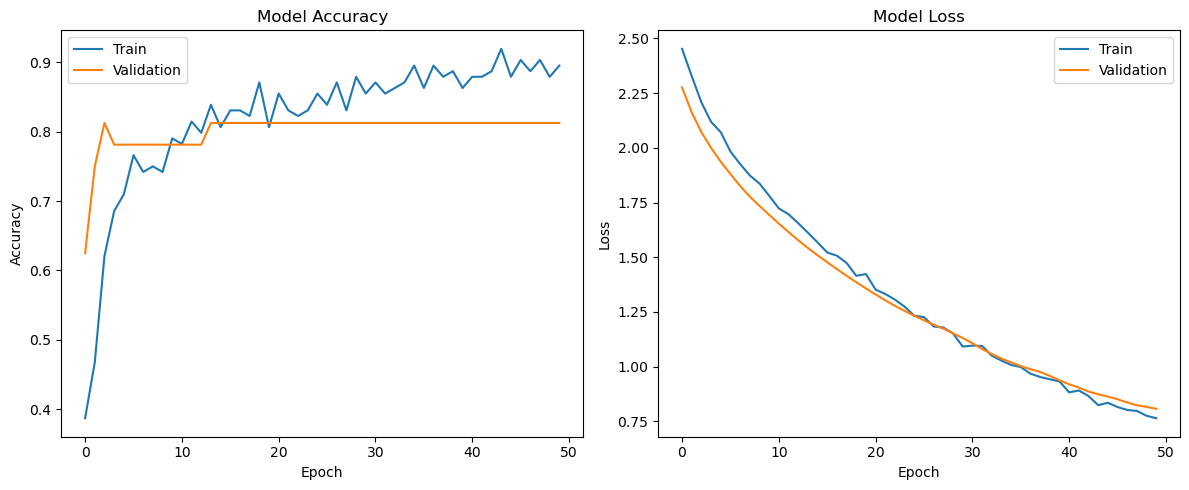

In [10]:
# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [11]:
# Predict probabilities on the test set
y_prob = best_model.predict(X_test)
y_prob

2/2 [==============================] - 0s 792us/step


array([[0.99755645],
       [0.8932654 ],
       [0.99091053],
       [0.748622  ],
       [0.980225  ],
       [0.94238883],
       [0.9945967 ],
       [0.8949347 ],
       [0.8104093 ],
       [0.37441275],
       [0.9492747 ],
       [0.9999097 ],
       [0.9741011 ],
       [0.99198246],
       [0.9997852 ],
       [0.99118084],
       [0.94142294],
       [0.68371415],
       [0.54009116],
       [0.9889823 ],
       [0.92064756],
       [0.51340073],
       [0.9536257 ],
       [0.03744549],
       [0.9913156 ],
       [0.9658441 ],
       [0.9615214 ],
       [0.9563016 ],
       [0.13153253],
       [0.9998987 ],
       [0.9881428 ],
       [0.918167  ],
       [0.91580516],
       [0.6833731 ],
       [0.8871046 ],
       [0.03156697],
       [0.9974483 ],
       [0.88235223],
       [0.86313885]], dtype=float32)

In [12]:
# Convert probabilities to binary class labels
y_test_pred = (y_prob > 0.5).astype(int).ravel()
y_test = y_test.astype(int).ravel()


In [13]:
# Print classification report
print(classification_report(y_test, y_test_pred, target_names=['No Parkinson\'s', 'Parkinson\'s']))

                precision    recall  f1-score   support

No Parkinson's       0.75      0.43      0.55         7
   Parkinson's       0.89      0.97      0.93        32

      accuracy                           0.87        39
     macro avg       0.82      0.70      0.74        39
  weighted avg       0.86      0.87      0.86        39



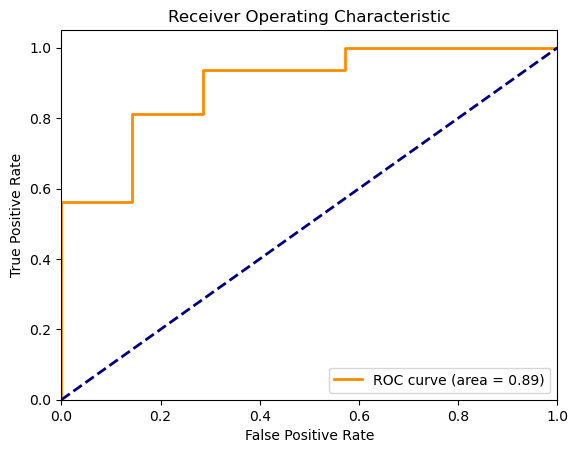

In [14]:
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


5/5 [==============================] - 0s 453us/step


  0%|          | 0/39 [00:00<?, ?it/s]

10199/10199 [==============================] - 2s 226us/step


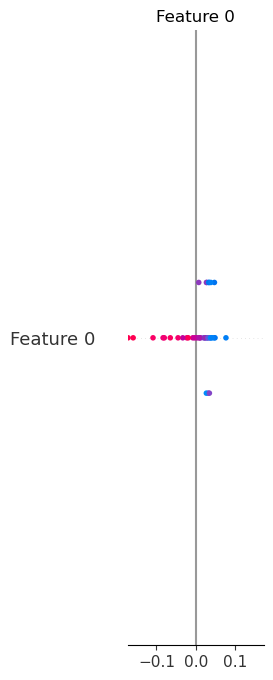

In [15]:
# SHAP Values
explainer = shap.KernelExplainer(best_model.predict, X_train)
shap_values = explainer.shap_values(X_test)

# Plot SHAP values
shap.summary_plot(shap_values, X_test)

In [16]:
# Extract a sample row from the dataset
# Take the first row
sample_row = X.iloc[0]

# Convert the row to a numpy array
new_sample = sample_row.values.reshape(1, -1)

# Preprocess and predict using the sample
new_sample_scaled = scaler.transform(new_sample)
new_sample_pred = best_model.predict(new_sample_scaled)
if new_sample_pred == 1:
    print("Parkinson's detected")
else:
    print("No Parkinson's")

1/1 [==============================] - 0s 9ms/step
No Parkinson's


/Users/venkatasrideepthisrikotapeetamabaram/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Epoch 1/100
13/13 [==============================] - 0s 4ms/step - loss: 0.5976 - accuracy: 0.6371 - val_loss: 0.4802 - val_accuracy: 0.7812
Epoch 2/100
13/13 [==============================] - 0s 1ms/step - loss: 0.4272 - accuracy: 0.8710 - val_loss: 0.3965 - val_accuracy: 0.7812
Epoch 3/100
13/13 [==============================] - 0s 1ms/step - loss: 0.3413 - accuracy: 0.8871 - val_loss: 0.3596 - val_accuracy: 0.7812
Epoch 4/100
13/13 [==============================] - 0s 1ms/step - loss: 0.2787 - accuracy: 0.8790 - val_loss: 0.3239 - val_accuracy: 0.8125
Epoch 5/100
13/13 [==============================] - 0s 1ms/step - loss: 0.2397 - accuracy: 0.9113 - val_loss: 0.3112 - val_accuracy: 0.8125
Epoch 6/100
13/13 [==============================] - 0s 992us/step - loss: 0.2201 - accuracy: 0.8952 - val_loss: 0.2811 - val_accuracy: 0.8125
Epoch 7/100
13/13 [==============================] - 0s 1ms/step - loss: 0.1770 - accuracy: 0.9274 - val_loss: 0.2884 - val_accuracy: 0.8125
Epoch 8/100

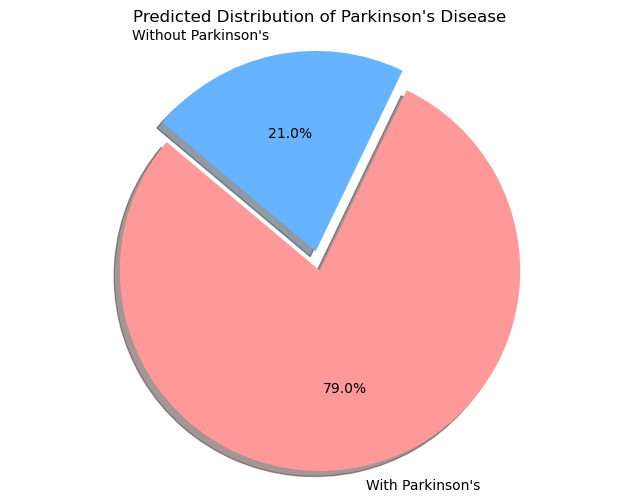

In [17]:
# Define and compile the model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.2)

# Standardize the entire feature set
X_scaled = scaler.transform(X)

# Standardize the entire feature set
X_scaled = scaler.transform(X)

# Predict the entire dataset
predictions = (model.predict(X_scaled) > 0.5).astype(int).ravel()

# Add predictions to the original dataset
data['predictions'] = predictions

# Print the number of samples with and without Parkinson's disease
num_with_disease = np.sum(predictions)
num_without_disease = len(predictions) - num_with_disease
print(f"Number of samples predicted to have Parkinson's: {num_with_disease}")
print(f"Number of samples predicted not to have Parkinson's: {num_without_disease}")

# Plot the results
labels = ['With Parkinson\'s', 'Without Parkinson\'s']
sizes = [num_with_disease, num_without_disease]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode 1st slice

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.title('Predicted Distribution of Parkinson\'s Disease')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
